## ETL
En esta etapa del proyecto, necesitaremos extraer, transformar y poner a disposición datos a partir de los conjuntos de datos recibidos. He optado por seguir dos enfoques diferentes:

1. Preparar los conjuntos de datos para satisfacer las consultas de cada endpoint propuesto.
2. Realizar la estructuración adecuada para entrenar e implementar un sistema de recomendaciones basado en técnicas de aprendizaje automático.


Agregaré comentarios en el código y títulos en formato markdown que sean claros en cuanto a las fases del ETL.


In [1]:
# Importamos las librerías necesarias para abrir y manejar los archivos
import numpy as np
import pandas as pd
import json
import ast
import warnings
warnings.filterwarnings("ignore")

# **1."output_steam_games"**

In [2]:
# Hacemos la lectura del archivo JSON
lista = []
with open("Data/output_steam_games.json", "r", encoding="utf-8") as file:
    for i in file.readlines():
        lista.append(json.loads(i))

df_1 = pd.DataFrame(lista)

In [3]:
# Instanciamos el DataFrame original en un segundo DF
# Esto lo hago con el objetivo de tener un punto de reinicio sin necesidad de volver a leer el JSON

df_output_steam_games = pd.DataFrame(df_1)

# Generamos una muestra del DataFrame para obtener contexto
df_output_steam_games

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


In [4]:
# Visualizamos la información general
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [5]:
# En EDA habíamos identificado una cantidad significativa de registros nulos
# Eliminamos dichos registros
df_output_steam_games = df_output_steam_games.dropna(how="all")

In [6]:
# Generamos inforación inicial para obtener contexto
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32135 entries, 88310 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 3.4+ MB


En este punto, y después de leer los endpoints propuestos, tenemos claridad sobre cuales son aquellas columnas que representan mayor relevancia, por tanto aplicamos algunas transformaciones pertinenetes sobre ellas, iremos rotulando y explicando cuál es motivación implícita en cada decisión

## Columna "id"

In [7]:
# Hacemos una revisión de los valores duplicados de "id"
# Si un valor duplicado en esta columna se entiende que hay información redundante
# Manejo esta hipótesis a partir de la premisa que cada juego tiene un Id único
duplicados = df_output_steam_games[df_output_steam_games.duplicated(subset="id", keep=False)]
duplicados

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88384,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,NaN,19.99,False,NaN,NaN
102204,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games
102883,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [8]:
# Hacemos la eliminación manteniendo uno de los registros
df_output_steam_games = df_output_steam_games.drop_duplicates(subset="id", keep="first", inplace=False)

In [9]:
df_output_steam_games["publisher"]

88310            Kotoshiro
88311     Making Fun, Inc.
88312         Poolians.com
88313                 彼岸领域
88314                  NaN
                ...       
120440     Ghost_RUS Games
120441              Sacada
120442        Laush Studio
120443            SIXNAILS
120444                 NaN
Name: publisher, Length: 32133, dtype: object

In [10]:
df_output_steam_games["developer"]

88310                    Kotoshiro
88311             Secret Level SRL
88312                 Poolians.com
88313                         彼岸领域
88314                          NaN
                    ...           
120440          Nikita "Ghost_RUS"
120441                      Sacada
120442    Laush Dmitriy Sergeevich
120443               xropi,stev3ns
120444                         NaN
Name: developer, Length: 32133, dtype: object

La información en estas dos columnas es muy similar, por lo tanto, decidimos conservar una de ellas. Si es posible, podríamos llenar los campos vacíos de una columna con los valores de la otra. Aunque ser editor no siempre significa ser desarrollador, esta estrategia de imputación es útil para completar valores faltantes con información aproximada.

In [11]:
# Visualizamos la cantidad de nulos en cada columna
cantidad_nulos_publisher = df_output_steam_games["publisher"].isnull().sum()
cantidad_nulos_developer = df_output_steam_games["developer"].isnull().sum()

print(cantidad_nulos_publisher, cantidad_nulos_developer)

8052 3299


In [12]:
# La columna "publisher" presenta mayor cantidad de datos nulos que la columna "developer"
# Por tanto, nos quedamos con la columna "developer" tratando de rellenar valores con datos de "publisher"
# Rellenar valores nulos en "developer" con los valores de "publisher" en el mismo registro
df_output_steam_games["developer"].fillna(df_output_steam_games["publisher"], inplace=True)

In [13]:
# Los registros en los que el valor de "developer" sigue siendo nulo se deben eliminar
cantidad_nulos_developer = df_output_steam_games["developer"].isnull().sum()
cantidad_nulos_developer

3234

In [14]:
# Recuperamos algunos valores de la columna "developer"
# Ahora hacemos la eliminación de la columna "publisher" y de los registros que quedaron vacios en "developer"
df_output_steam_games.drop("publisher", axis=1, inplace=True)
df_output_steam_games.dropna(subset=["developer"], inplace=True)
df_output_steam_games.info() # Generamos información general

<class 'pandas.core.frame.DataFrame'>
Index: 28899 entries, 88310 to 120443
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        28733 non-null  object
 1   app_name      28899 non-null  object
 2   title         28899 non-null  object
 3   url           28899 non-null  object
 4   release_date  28881 non-null  object
 5   tags          28761 non-null  object
 6   reviews_url   28899 non-null  object
 7   specs         28613 non-null  object
 8   price         27662 non-null  object
 9   early_access  28899 non-null  object
 10  id            28899 non-null  object
 11  developer     28899 non-null  object
dtypes: object(12)
memory usage: 2.9+ MB


## Columnas "genres" y "tags"

In [15]:
df_output_steam_games["genres"]

88310         [Action, Casual, Indie, Simulation, Strategy]
88311                  [Free to Play, Indie, RPG, Strategy]
88312     [Casual, Free to Play, Indie, Simulation, Sports]
88313                           [Action, Adventure, Casual]
88315                       [Action, Adventure, Simulation]
                                ...                        
120439                   [Action, Adventure, Casual, Indie]
120440                [Casual, Indie, Simulation, Strategy]
120441                            [Casual, Indie, Strategy]
120442                          [Indie, Racing, Simulation]
120443                                      [Casual, Indie]
Name: genres, Length: 28899, dtype: object

In [16]:
df_output_steam_games["tags"]

88310         [Strategy, Action, Indie, Casual, Simulation]
88311     [Free to Play, Strategy, Indie, RPG, Card Game...
88312     [Free to Play, Simulation, Sports, Casual, Ind...
88313                           [Action, Adventure, Casual]
88315     [Action, Adventure, Simulation, FPS, Shooter, ...
                                ...                        
120439          [Action, Indie, Casual, Violent, Adventure]
120440                [Strategy, Indie, Casual, Simulation]
120441                            [Strategy, Indie, Casual]
120442                          [Indie, Simulation, Racing]
120443    [Indie, Casual, Puzzle, Singleplayer, Atmosphe...
Name: tags, Length: 28899, dtype: object

Entre estas dos columnas ocurre algo parecido al caso anterior, por lo tanto, hemos optado por completar los valores faltantes de "géneros" con los disponibles en "etiquetas". Aunque los valores de "etiquetas" pueden incluir algunas etiquetas que no son géneros en sí mismas, como "un jugador" o "multijugador", esas etiquetas no serían significativamente relevantes en la columna "géneros".

In [17]:
# Obtenemos la cantidad de nulos en "genres"
cantidad_nulos_genres = df_output_steam_games["genres"].isnull().sum()
cantidad_nulos_genres

166

In [18]:
# Rellenamos los valores nulos en "genres" con los valores de "tags" en el mismo registro
df_output_steam_games["genres"].fillna(df_output_steam_games["tags"], inplace=True)

In [19]:
# La cantidad de registros campos nulos en "genres" debe disminuir
cantidad_nulos_genres = df_output_steam_games["genres"].isnull().sum()
cantidad_nulos_genres

114

In [20]:
# Eliminamos la columna "tags" y los registros donde "genres" sigue nulo
df_output_steam_games.drop("tags", axis=1, inplace=True)
df_output_steam_games.dropna(subset=["genres"], inplace=True)
df_output_steam_games.info() # Generamos información general

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        28785 non-null  object
 1   app_name      28785 non-null  object
 2   title         28785 non-null  object
 3   url           28785 non-null  object
 4   release_date  28767 non-null  object
 5   reviews_url   28785 non-null  object
 6   specs         28499 non-null  object
 7   price         27564 non-null  object
 8   early_access  28785 non-null  object
 9   id            28785 non-null  object
 10  developer     28785 non-null  object
dtypes: object(11)
memory usage: 2.6+ MB


## Columnas "app_name" y "title"

In [21]:
df_output_steam_games["app_name"]

88310          Lost Summoner Kitty
88311                    Ironbound
88312      Real Pool 3D - Poolians
88313                      弹炸人2222
88315        Battle Royale Trainer
                    ...           
120439                Kebab it Up!
120440              Colony On Mars
120441    LOGistICAL: South Africa
120442               Russian Roads
120443         EXIT 2 - Directions
Name: app_name, Length: 28785, dtype: object

In [22]:
df_output_steam_games["title"]

88310          Lost Summoner Kitty
88311                    Ironbound
88312      Real Pool 3D - Poolians
88313                      弹炸人2222
88315        Battle Royale Trainer
                    ...           
120439                Kebab it Up!
120440              Colony On Mars
120441    LOGistICAL: South Africa
120442               Russian Roads
120443         EXIT 2 - Directions
Name: title, Length: 28785, dtype: object

Estas dos columnas también contienen valores similares como en el caso de las dos parejas de columnas anteriores. Por tanto podemos rescatar valores en una a partir de la otra.

In [23]:
# Visualizamos la cantidad de nulos en cada columna
cantidad_nulos_app_name = df_output_steam_games["app_name"].isnull().sum()
cantidad_nulos_title = df_output_steam_games["title"].isnull().sum()

print(cantidad_nulos_app_name, cantidad_nulos_title)

0 0


In [24]:
# "app_name" y "title" no tienen valores nulos
# Vamos a calcular que porcentaje de similitud tienen
total_filas = len(df_output_steam_games)
valores_coincidentes = (df_output_steam_games["app_name"] == df_output_steam_games["title"]).sum()

porcentaje_similitud = (valores_coincidentes / total_filas) * 100
print(f"El porcentaje de similitud entre 'app_name' y 'title' es: {porcentaje_similitud:.2f}%")

El porcentaje de similitud entre 'app_name' y 'title' es: 98.11%


In [25]:
# Eliminamos "app_name"
# Puesto que título puede diferenciarse en alguna versión especial o capítulo del juego
df_output_steam_games.drop("app_name", axis=1, inplace=True)
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        28785 non-null  object
 1   title         28785 non-null  object
 2   url           28785 non-null  object
 3   release_date  28767 non-null  object
 4   reviews_url   28785 non-null  object
 5   specs         28499 non-null  object
 6   price         27564 non-null  object
 7   early_access  28785 non-null  object
 8   id            28785 non-null  object
 9   developer     28785 non-null  object
dtypes: object(10)
memory usage: 2.4+ MB


## Columna "release_date"


In [26]:
df_output_steam_games["release_date"]

88310     2018-01-04
88311     2018-01-04
88312     2017-07-24
88313     2017-12-07
88315     2018-01-04
             ...    
120439    2018-01-04
120440    2018-01-04
120441    2018-01-04
120442    2018-01-04
120443    2017-09-02
Name: release_date, Length: 28785, dtype: object

De esta columna podemos extraer el dato del año en una nueva columna, dado que es el valor relevante para el trabajo

In [28]:
# Creamos la columna con el año de lanzamiento
df_output_steam_games["release_year"] = df_output_steam_games["release_date"].str.extract(r"(\d{4})")

# Eliminamos la columna innecesaria
df_output_steam_games.drop("release_date", axis=1, inplace=True)

# Mostramos información del DataFrame
df_output_steam_games["release_year"]

88310     2018
88311     2018
88312     2017
88313     2017
88315     2018
          ... 
120439    2018
120440    2018
120441    2018
120442    2018
120443    2017
Name: release_year, Length: 28785, dtype: object

In [29]:
# Hacemos un conteo de nulos en la columna que hemos generado
cantidad_nulos_release_year = df_output_steam_games["release_year"].isnull().sum()
cantidad_nulos_release_year

119

In [33]:
# Podemos rellenar los nulos en la columna "release_year" con el valor de la mediana
df_output_steam_games["release_year"] = pd.to_numeric(df_output_steam_games["release_year"], errors='coerce')

# Calculamos la mediana
mediana_release_year = df_output_steam_games["release_year"].median()

# Rellenamos los nulos con el valor de la mediana
df_output_steam_games["release_year"].fillna(mediana_release_year, inplace=True)

In [34]:
# Verificamos que no queden valores nulos
cantidad_nulos_release_year = df_output_steam_games["release_year"].isnull().sum()
cantidad_nulos_release_year

0

In [35]:
# Revisamos la información general
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28785 non-null  object 
 1   title         28785 non-null  object 
 2   url           28785 non-null  object 
 3   reviews_url   28785 non-null  object 
 4   specs         28499 non-null  object 
 5   price         27564 non-null  object 
 6   early_access  28785 non-null  object 
 7   id            28785 non-null  object 
 8   developer     28785 non-null  object 
 9   release_year  28785 non-null  float64
dtypes: float64(1), object(9)
memory usage: 2.4+ MB


## Columna "price"

In [36]:
df_output_steam_games["price"]

88310             4.99
88311     Free To Play
88312     Free to Play
88313             0.99
88315             3.99
              ...     
120439            1.99
120440            1.99
120441            4.99
120442            1.99
120443            4.99
Name: price, Length: 28785, dtype: object

Esta columna debe ser estandarizada a un solo tipo de dato, preferiblemente numérico.

Debemos rellenar los datos nulos con el valor de la media o la mediana.

In [37]:
# Convertimos los valores string, no nulos, a 0.0 (float)
df_output_steam_games["price"] = pd.to_numeric(df_output_steam_games["price"], errors="coerce")

# Convertimos a 0.0 los valores que contienen 'f' o 'F' en la columna 'price', por "free" o "Free"
df_output_steam_games.loc[df_output_steam_games["price"].astype(str).str.contains("[fF]"), "price"] = 0.0

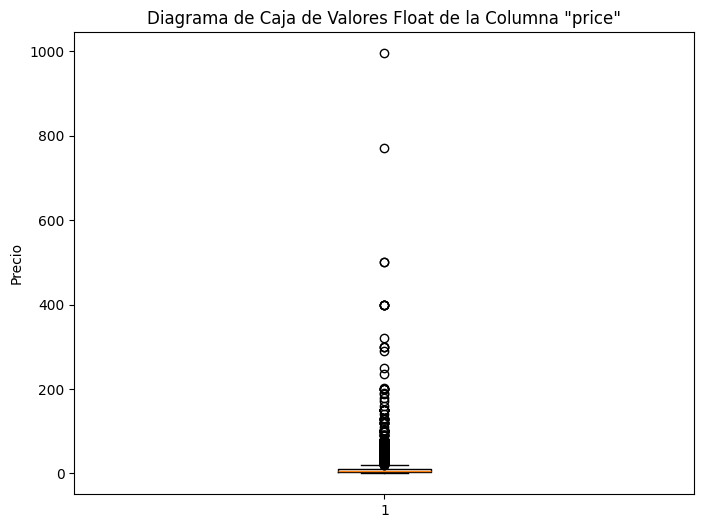

In [38]:
import matplotlib.pyplot as plt

# Filtramos valores numéricos en la columna "price" excluyendo "nan"
valores_numericos = df_output_steam_games['price'][(df_output_steam_games['price'] != 'nan')]

# Crear el diagrama de caja
plt.figure(figsize=(8, 6))
plt.boxplot(valores_numericos.dropna())  # Eliminar valores NaN
plt.title('Diagrama de Caja de Valores Float de la Columna "price"')
plt.ylabel('Precio')
plt.show()

In [39]:
# Decidimos rellenar los valores nulos con la media de los precios
# Dado que hay outliers alejados de la media que podrían sesgarla
mediana_price = df_output_steam_games["price"].median()
df_output_steam_games["price"].fillna(mediana_price, inplace=True)
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28785 non-null  object 
 1   title         28785 non-null  object 
 2   url           28785 non-null  object 
 3   reviews_url   28785 non-null  object 
 4   specs         28499 non-null  object 
 5   price         28785 non-null  float64
 6   early_access  28785 non-null  object 
 7   id            28785 non-null  object 
 8   developer     28785 non-null  object 
 9   release_year  28785 non-null  float64
dtypes: float64(2), object(8)
memory usage: 2.4+ MB


## Columna "specs"


In [40]:
df_output_steam_games["specs"]

88310                                       [Single-player]
88311     [Single-player, Multi-player, Online Multi-Pla...
88312     [Single-player, Multi-player, Online Multi-Pla...
88313                                       [Single-player]
88315                   [Single-player, Steam Achievements]
                                ...                        
120439     [Single-player, Steam Achievements, Steam Cloud]
120440                  [Single-player, Steam Achievements]
120441    [Single-player, Steam Achievements, Steam Clou...
120442    [Single-player, Steam Achievements, Steam Trad...
120443     [Single-player, Steam Achievements, Steam Cloud]
Name: specs, Length: 28785, dtype: object

Podemos rellenar los nulos de esta columna con el valor "no specifications".

In [41]:
# Rellenar los valores nulos en la columna "specs" con "sin detalles"
df_output_steam_games["specs"].fillna("no specifications", inplace=True)
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28785 non-null  object 
 1   title         28785 non-null  object 
 2   url           28785 non-null  object 
 3   reviews_url   28785 non-null  object 
 4   specs         28785 non-null  object 
 5   price         28785 non-null  float64
 6   early_access  28785 non-null  object 
 7   id            28785 non-null  object 
 8   developer     28785 non-null  object 
 9   release_year  28785 non-null  float64
dtypes: float64(2), object(8)
memory usage: 2.4+ MB


## Columnas "url" y "reviews_url

In [42]:
df_output_steam_games["url"]

88310     http://store.steampowered.com/app/761140/Lost_...
88311     http://store.steampowered.com/app/643980/Ironb...
88312     http://store.steampowered.com/app/670290/Real_...
88313        http://store.steampowered.com/app/767400/2222/
88315     http://store.steampowered.com/app/772540/Battl...
                                ...                        
120439    http://store.steampowered.com/app/745400/Kebab...
120440    http://store.steampowered.com/app/773640/Colon...
120441    http://store.steampowered.com/app/733530/LOGis...
120442    http://store.steampowered.com/app/610660/Russi...
120443    http://store.steampowered.com/app/658870/EXIT_...
Name: url, Length: 28785, dtype: object

In [43]:
df_output_steam_games["reviews_url"]

88310     http://steamcommunity.com/app/761140/reviews/?...
88311     http://steamcommunity.com/app/643980/reviews/?...
88312     http://steamcommunity.com/app/670290/reviews/?...
88313     http://steamcommunity.com/app/767400/reviews/?...
88315     http://steamcommunity.com/app/772540/reviews/?...
                                ...                        
120439    http://steamcommunity.com/app/745400/reviews/?...
120440    http://steamcommunity.com/app/773640/reviews/?...
120441    http://steamcommunity.com/app/733530/reviews/?...
120442    http://steamcommunity.com/app/610660/reviews/?...
120443    http://steamcommunity.com/app/658870/reviews/?...
Name: reviews_url, Length: 28785, dtype: object

Decidimos borrar estas columnas, dado que no son relevantes para los endpoints de la API, el modelo de ML o el EDA.

In [44]:
# Eliminamos las columnas
df_output_steam_games.drop(["url", "reviews_url"], axis=1, inplace=True)
df_output_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28785 non-null  object 
 1   title         28785 non-null  object 
 2   specs         28785 non-null  object 
 3   price         28785 non-null  float64
 4   early_access  28785 non-null  object 
 5   id            28785 non-null  object 
 6   developer     28785 non-null  object 
 7   release_year  28785 non-null  float64
dtypes: float64(2), object(6)
memory usage: 2.0+ MB


## Disponibilizamos un archivo CSV con nuestro DF

In [45]:
df_output_steam_games.to_csv("Data/df_output_steam_games")

# **2- "australian_users_items"**

In [46]:
# Leemos el archivo JSON y procedemos a crear un DF
australian_users_items = []
with open("Data/australian_users_items.json", "r", encoding="utf-8") as file:
    for i in file.readlines():
        australian_users_items.append(ast.literal_eval(i))

df_2 = pd.DataFrame(australian_users_items)

In [47]:
# Instanciamos el DataFrame original en un segundo DF
# Esto lo hago con el objetivo de tener un punto de reinicio sin necesidad de volver a leer el JSON
df_australian_users_items = pd.DataFrame(df_2)
df_australian_users_items # Generamos una muestra del DF para obtener contexto

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


In [48]:
# Visualizamos la información general
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


Este DF tiene la información relevante en la columna items, por tanto debemos aplicar una técnica para desanidarla en columnas.

In [49]:
df_australian_users_items["items"][0]

[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

In [50]:
# Tras revisar el contenido de la columna items, aplicamos el método "json_normalize()" para aplanar las estructuras JSON y convertirlas en una tabla.
# Conservando las otras columnas del DF inicial
df_australian_users_items = pd.json_normalize(australian_users_items, record_path="items", meta=["steam_id", "items_count", "user_id", "user_url"])
df_australian_users_items

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,user_url
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
...,...,...,...,...,...,...,...,...
5153204,346330,BrainBread 2,0,0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153205,373330,All Is Dust,0,0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153206,388490,One Way To Die: Steam Edition,3,3,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153207,521570,You Have 10 Seconds 2,4,4,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...


In [51]:
# Visualizamos nuevamente la información general
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 8 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           object
 1   item_name         object
 2   playtime_forever  int64 
 3   playtime_2weeks   int64 
 4   steam_id          object
 5   items_count       object
 6   user_id           object
 7   user_url          object
dtypes: int64(2), object(6)
memory usage: 314.5+ MB


## Columna "user_url"

Esta columna la podemos eliminar, dado que no aporta información relevante para la API.

In [52]:
df_australian_users_items.drop(["user_url"], axis=1, inplace=True)
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           object
 1   item_name         object
 2   playtime_forever  int64 
 3   playtime_2weeks   int64 
 4   steam_id          object
 5   items_count       object
 6   user_id           object
dtypes: int64(2), object(5)
memory usage: 275.2+ MB


## Columna "item_id"

Esta columna es importante porque a partir de ella traeremos a nuestro DataFrame de las  columnas relevantes como los géneros, años de lanzamiento y precio de los juegos de cada usuario.

Sus valores nulos no pueden recuperarse, así que aquellos registros que contengan valores nulos en esta columna serán eliminados.

In [53]:
# Eliminamos tales registros
df_australian_users_items.dropna(subset=["item_id"], inplace=True)
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           object
 1   item_name         object
 2   playtime_forever  int64 
 3   playtime_2weeks   int64 
 4   steam_id          object
 5   items_count       object
 6   user_id           object
dtypes: int64(2), object(5)
memory usage: 275.2+ MB


A partir de este DataFrame podemos agregar algunas columnas relevantes para enriquecer los datos.

Antes de hacer el merged debemos convertir al mismo tipo de dato la columna que tomaremos de cada DataFrame, es decir; "item_id" y "id"

In [54]:
df_australian_users_items["item_id"] = df_australian_users_items["item_id"].astype(int)
df_output_steam_games["id"] = df_output_steam_games["id"].astype(int)
print(df_australian_users_items["item_id"].info(), df_output_steam_games["id"].info())

<class 'pandas.core.series.Series'>
RangeIndex: 5153209 entries, 0 to 5153208
Series name: item_id
Non-Null Count    Dtype
--------------    -----
5153209 non-null  int32
dtypes: int32(1)
memory usage: 19.7 MB
<class 'pandas.core.series.Series'>
Index: 28785 entries, 88310 to 120443
Series name: id
Non-Null Count  Dtype
--------------  -----
28785 non-null  int32
dtypes: int32(1)
memory usage: 337.3 KB
None None


Hacemos el merged para agregar las columnas relevantes.

In [55]:
df_australian_users_items = pd.merge(df_australian_users_items, df_output_steam_games[["id", "genres", "price", "developer", "release_year"]], how="left", left_on="item_id", right_on="id")
df_australian_users_items

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,id,genres,price,developer,release_year
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,10.0,[Action],9.99,Valve,2000.0
1,20,Team Fortress Classic,0,0,76561197970982479,277,76561197970982479,20.0,[Action],4.99,Valve,1999.0
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,30.0,[Action],4.99,Valve,2003.0
3,40,Deathmatch Classic,0,0,76561197970982479,277,76561197970982479,40.0,[Action],4.99,Valve,2001.0
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,76561197970982479,50.0,[Action],4.99,Gearbox Software,1999.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5153204,346330,BrainBread 2,0,0,76561198329548331,7,76561198329548331,346330.0,"[Action, Adventure, Free to Play, Indie, Early...",4.99,Reperio Studios,2016.0
5153205,373330,All Is Dust,0,0,76561198329548331,7,76561198329548331,NaN,NaN,NaN,NaN,NaN
5153206,388490,One Way To Die: Steam Edition,3,3,76561198329548331,7,76561198329548331,388490.0,"[Adventure, Free to Play]",4.99,CoaguCo Industries,2015.0
5153207,521570,You Have 10 Seconds 2,4,4,76561198329548331,7,76561198329548331,521570.0,"[Casual, Free to Play, Indie]",4.99,Tamationgames,2016.0


Tras aplicar el merged, vemos que algunos de los campos quedan nulos, por tanto debemos tratar de recuperar lo posible y eliminar los registros restantes.

Podemos hacer la revisión de nulos a partir de una función que muestre la cantidad y el porcentaje de estos por cada columna, y a partir de allí, realizar las tranformaciones pertinentes sobre el DataFrame.

In [56]:
def info_nulos(df, decimales=2):
    df_nulos = pd.DataFrame({
        "columna": df.columns,
        "Número de nulos": df.isnull().sum(),
        "Porcentaje de nulos": (df.isnull().sum() / df.shape[0]) * 100.0
    })
    df_nulos["Porcentaje de nulos"] = df_nulos["Porcentaje de nulos"].round(decimales).astype(str) + "%"
    return df_nulos

info_nulos(df_australian_users_items)

,columna,Número de nulos,Porcentaje de nulos
item_id,item_id,0,0.0%
item_name,item_name,0,0.0%
playtime_forever,playtime_forever,0,0.0%
playtime_2weeks,playtime_2weeks,0,0.0%
steam_id,steam_id,0,0.0%
items_count,items_count,0,0.0%
user_id,user_id,0,0.0%
id,id,945406,18.35%
genres,genres,945406,18.35%
price,price,945406,18.35%


El DataFrame resultante del merged tiene un 18.35% de datos faltantes en las columnas que originalmente pertenecían al DataFrame "df_outputs_steam_games", por tanto, debemos aplicar las tranformaciones necesarias.

## Columnas "item_id" y "id"

In [57]:
# Las columnas "item_id" y "id" tienen los mismos datos, es decir, representan lo mismo
# Eliminamos "id" tras comprobar que "item_id" no tiene datos nulos
df_australian_users_items.drop("id", axis=1, inplace=True)
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int32  
 1   item_name         object 
 2   playtime_forever  int64  
 3   playtime_2weeks   int64  
 4   steam_id          object 
 5   items_count       object 
 6   user_id           object 
 7   genres            object 
 8   price             float64
 9   developer         object 
 10  release_year      float64
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 412.8+ MB


In [58]:
info_nulos(df_australian_users_items)

,columna,Número de nulos,Porcentaje de nulos
item_id,item_id,0,0.0%
item_name,item_name,0,0.0%
playtime_forever,playtime_forever,0,0.0%
playtime_2weeks,playtime_2weeks,0,0.0%
steam_id,steam_id,0,0.0%
items_count,items_count,0,0.0%
user_id,user_id,0,0.0%
genres,genres,945406,18.35%
price,price,945406,18.35%
developer,developer,945406,18.35%


Tenemos que determinar si los registros que contienen valores nulos en las cuatro columnas restantes son los mismos. En caso afirmativo, esos registros deberían eliminarse, ya que las columnas "géneros" y "precio" no podrían recuperarse a partir de otra columna.

In [59]:
# Filtramos los registros donde una de las columnas tiene valores nulos
df_muestra = df_australian_users_items[df_australian_users_items["genres"].isnull()].copy()
info_nulos(df_muestra)

,columna,Número de nulos,Porcentaje de nulos
item_id,item_id,0,0.0%
item_name,item_name,0,0.0%
playtime_forever,playtime_forever,0,0.0%
playtime_2weeks,playtime_2weeks,0,0.0%
steam_id,steam_id,0,0.0%
items_count,items_count,0,0.0%
user_id,user_id,0,0.0%
genres,genres,945406,100.0%
price,price,945406,100.0%
developer,developer,945406,100.0%


In [60]:
# Eliminamos dichos registros
df_australian_users_items.dropna(subset=["genres"], inplace=True)
info_nulos(df_australian_users_items)

,columna,Número de nulos,Porcentaje de nulos
item_id,item_id,0,0.0%
item_name,item_name,0,0.0%
playtime_forever,playtime_forever,0,0.0%
playtime_2weeks,playtime_2weeks,0,0.0%
steam_id,steam_id,0,0.0%
items_count,items_count,0,0.0%
user_id,user_id,0,0.0%
genres,genres,0,0.0%
price,price,0,0.0%
developer,developer,0,0.0%


En este punto debemos rectificar los tipos de datos numéricos de las columnas que necesitemos para los endpoints de la API.

In [61]:
# Verificamos los tipos de datos para saber cuales columnas necesitan la modificación
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4207803 entries, 0 to 5153207
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int32  
 1   item_name         object 
 2   playtime_forever  int64  
 3   playtime_2weeks   int64  
 4   steam_id          object 
 5   items_count       object 
 6   user_id           object 
 7   genres            object 
 8   price             float64
 9   developer         object 
 10  release_year      float64
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 369.2+ MB


In [62]:
# La columna "items_count" necesita ser de tipo int, para aplicar futuras operaciones de ser necesario
df_australian_users_items["items_count"] = df_australian_users_items["items_count"].astype(int)
df_australian_users_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4207803 entries, 0 to 5153207
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int32  
 1   item_name         object 
 2   playtime_forever  int64  
 3   playtime_2weeks   int64  
 4   steam_id          object 
 5   items_count       int32  
 6   user_id           object 
 7   genres            object 
 8   price             float64
 9   developer         object 
 10  release_year      float64
dtypes: float64(2), int32(2), int64(2), object(5)
memory usage: 353.1+ MB


En este punto disponibilizamos un DF que contiene 4 de las 11 columnas, la utilidad de este DF será suplir las consultas de los dos primeros endpoints propuestos.

Aclaro que hago la selección específica de columnas por temas de optimización al momento de hacer el deploy en Render.

In [63]:
# Creamos un DataFrame con las columnas seleccionadas
df_endpoints_1_2 = df_australian_users_items.loc[:, ["genres", "release_year", "playtime_forever", "user_id"]].copy()
df_endpoints_1_2

,genres,release_year,playtime_forever,user_id
0,[Action],2000.0,6,76561197970982479
1,[Action],1999.0,0,76561197970982479
2,[Action],2003.0,7,76561197970982479
3,[Action],2001.0,0,76561197970982479
4,[Action],1999.0,0,76561197970982479
...,...,...,...,...
5153202,"[Action, Adventure, Casual, Free to Play, Indie]",2017.0,677,76561198329548331
5153203,"[Action, Free to Play, Indie, Massively Multip...",2016.0,43,76561198329548331
5153204,"[Action, Adventure, Free to Play, Indie, Early...",2016.0,0,76561198329548331
5153206,"[Adventure, Free to Play]",2015.0,3,76561198329548331


Para las consultas propuestas no nos sirven aquellos registros sin tiempo de juego, por tanto, son eliminados.

In [64]:
# Eliminamos los registros donde "playtime_forever" tiene valor de 0
df_endpoints_1_2 = df_endpoints_1_2[df_endpoints_1_2["playtime_forever"] != 0]
df_endpoints_1_2

,genres,release_year,playtime_forever,user_id
0,[Action],2000.0,6,76561197970982479
2,[Action],2003.0,7,76561197970982479
8,[Action],2010.0,4733,76561197970982479
9,[Action],2004.0,1853,76561197970982479
10,[Action],2005.0,333,76561197970982479
...,...,...,...,...
5153024,"[Adventure, Casual, Free to Play, Indie, Simul...",2015.0,8,76561198323066619
5153202,"[Action, Adventure, Casual, Free to Play, Indie]",2017.0,677,76561198329548331
5153203,"[Action, Free to Play, Indie, Massively Multip...",2016.0,43,76561198329548331
5153206,"[Adventure, Free to Play]",2015.0,3,76561198329548331


En este punto podríamos disponibilizar un archivo con nuestro DataFrame, no obstante, queremos realizar algún tipo de preprocesamiento de los datos para disminuir los requerimientos de procesamiento de nuestra función al momento de deployear la API en Render.

In [65]:
# Hacemos un explode sobre la columna "genres"
df_endpoints_1_2 = df_endpoints_1_2.explode("genres", ignore_index=False)

In [66]:
df_endpoints_1_2

,genres,release_year,playtime_forever,user_id
0,Action,2000.0,6,76561197970982479
2,Action,2003.0,7,76561197970982479
8,Action,2010.0,4733,76561197970982479
9,Action,2004.0,1853,76561197970982479
10,Action,2005.0,333,76561197970982479
...,...,...,...,...
5153206,Adventure,2015.0,3,76561198329548331
5153206,Free to Play,2015.0,3,76561198329548331
5153207,Casual,2016.0,4,76561198329548331
5153207,Free to Play,2016.0,4,76561198329548331


In [67]:
df_endpoints_1_2 = df_endpoints_1_2.reset_index()

In [68]:
# Convertimos los tipos de datos de la columna "release_year" a int
df_endpoints_1_2["release_year"] = df_endpoints_1_2["release_year"].astype(int)

## Creamos una función que crea un dataframe con datos preprocesados par satisfacer la consulta del primer endpoint de la API.


In [69]:
def calcular_horas_por_genero_y_año(df):
    resultados = []

    generos_unicos = df['genres'].unique()

    for genero in generos_unicos:
        df_genero = df[df['genres'] == genero]
        
        años_unicos = df_genero['release_year'].unique()
        
        for año in años_unicos:
            horas_jugadas = df_genero[df_genero['release_year'] == año]['playtime_forever'].sum()
            resultados.append({'genres': genero, 'release_year': año, 'playtime': horas_jugadas})
    
    return pd.DataFrame(resultados)

In [70]:
endpoint_1 = calcular_horas_por_genero_y_año(df_endpoints_1_2)

In [71]:
endpoint_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        411 non-null    object
 1   release_year  411 non-null    int32 
 2   playtime      411 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 8.2+ KB


In [72]:
endpoint_1["release_year"] = endpoint_1["release_year"].astype(int)
endpoint_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        411 non-null    object
 1   release_year  411 non-null    int32 
 2   playtime      411 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 8.2+ KB


In [73]:
# Disponibilizamos el archivo sobre el cual haremos la consulta
endpoint_1.to_parquet("Data/endpoint_1")

In [74]:
# Definimos una función que pueda crear un dataframe sobre el que haremos la consulta de un endpoint
def calcular_horas_por_usuario_genero_año(df):
    # Agrupar por usuario, género y año, sumando las horas de juego
    resultados = df.groupby(['user_id', 'genres', 'release_year'])['playtime_forever'].sum().reset_index()
    resultados.rename(columns={'playtime_forever': 'playtime'}, inplace=True)
    return pd.DataFrame(resultados)

In [75]:
endpoint_2 = calcular_horas_por_usuario_genero_año(df_endpoints_1_2)
endpoint_2

,user_id,genres,release_year,playtime
0,--000--,Action,2009,5329
1,--000--,Action,2010,22
2,--000--,Action,2011,6522
3,--000--,Action,2012,109346
4,--000--,Action,2013,363
...,...,...,...,...
2879091,zzzmidmiss,Sports,2010,194
2879092,zzzmidmiss,Sports,2014,16
2879093,zzzmidmiss,Strategy,2010,10
2879094,zzzmidmiss,Strategy,2011,69


In [76]:
endpoint_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879096 entries, 0 to 2879095
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   genres        object
 2   release_year  int32 
 3   playtime      int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 76.9+ MB


Podemos disponibilizar un parquet para hacer la consulta del endpoint 2.

In [77]:
endpoint_2.to_parquet("endpoint_2")

In [78]:
df_australian_users_items["release_year"] = df_australian_users_items["release_year"].astype(int)

Podemos disponibilizar un archivo que nos servirá para construir el modelo de ML.

In [79]:
df_australian_users_items.to_parquet("Data/df_australian_users_items")

# **3- "australian_users_reviews"**

In [80]:
# Hacemos la lectura del JSON
lista = []
with open("Data/australian_user_reviews.json", "r", encoding="utf-8") as file:
    for i in file:
        lista.append(ast.literal_eval(i))

df_3 = pd.DataFrame(lista)

In [81]:
# Instanciamos el DF en otro para tener punto de recarga sin necesidad de volver a leer el JSON
df_australian_user_reviews = pd.DataFrame(df_3)
df_australian_user_reviews # Generamos una muestra

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."
...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,"[{'funny': '', 'posted': 'Posted May 31.', 'la..."
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,"[{'funny': '', 'posted': 'Posted June 17.', 'l..."
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,"[{'funny': '1 person found this review funny',..."
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"[{'funny': '', 'posted': 'Posted July 21.', 'l..."


In [82]:
# Visualizamos la información general
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [83]:
df_australian_user_reviews["reviews"][0]

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

La columna "reviews" contiene datos anidados, debemos desanidarla en otras columnas para ver trabajar en las transformaciones

In [84]:
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [85]:
# Tras revisar el contenido de la columna reviews, aplicamos el método "explode" para desanidarla
# Concatenamos el resultado con el DataFrame original y borramos la columna "reviews" con datos anidados
df_australian_user_reviews = df_australian_user_reviews.explode("reviews").reset_index()
df_australian_user_reviews = pd.concat([df_australian_user_reviews.drop(columns="reviews"), df_australian_user_reviews["reviews"].apply(pd.Series)],axis=1)
df_australian_user_reviews # Generamos una muestra

,index,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,0
0,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,NaN
1,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,NaN
2,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,NaN
3,1,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,NaN
4,1,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59328,25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...,NaN
59329,25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...,NaN
59330,25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...,NaN
59331,25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,,Posted July 20.,,730,No ratings yet,True,:D,NaN


In [86]:
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        59333 non-null  int64  
 1   user_id      59333 non-null  object 
 2   user_url     59333 non-null  object 
 3   funny        59305 non-null  object 
 4   posted       59305 non-null  object 
 5   last_edited  59305 non-null  object 
 6   item_id      59305 non-null  object 
 7   helpful      59305 non-null  object 
 8   recommend    59305 non-null  object 
 9   review       59305 non-null  object 
 10  0            0 non-null      float64
dtypes: float64(1), int64(1), object(9)
memory usage: 5.0+ MB


In [87]:
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
index,index,0,0.0%
user_id,user_id,0,0.0%
user_url,user_url,0,0.0%
funny,funny,28,0.05%
posted,posted,28,0.05%
last_edited,last_edited,28,0.05%
item_id,item_id,28,0.05%
helpful,helpful,28,0.05%
recommend,recommend,28,0.05%
review,review,28,0.05%


Ya hemos desanidado la columna "reviews", ahora vamos a eliminar las columnas que no son relevantes para los endpoints propuestos.

In [88]:
df_australian_user_reviews = df_australian_user_reviews.drop(columns=["index", "funny", "user_url", "last_edited", "helpful", 0])
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59333 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  object
 4   review     59305 non-null  object
dtypes: object(5)
memory usage: 2.3+ MB


## Transformación columna "posted"

Para nuestros propósitos nos sirve el año de posteo sin detallar día y mes, por tanto, debemos extraer el valor del año en una nueva columna y eliminar "posted".

In [89]:
df_australian_user_reviews["posted_year"] = df_australian_user_reviews["posted"].str.extract(r"(\d{4})")

In [90]:
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
posted,posted,28,0.05%
item_id,item_id,28,0.05%
recommend,recommend,28,0.05%
review,review,28,0.05%
posted_year,posted_year,10147,17.1%


In [96]:
# Podemos hacer rellenar los nulos en la columna "posted_year" con el valor de la mediana
df_australian_user_reviews["posted_year"] = pd.to_numeric(df_australian_user_reviews["posted_year"], errors='coerce')

# Calculamos la mediana
mediana_posted_year = df_australian_user_reviews["posted_year"].median()

# Rellenamos los nulos con el valor de la mediana
df_australian_user_reviews["posted_year"].fillna(mediana_posted_year, inplace=True)
df_australian_user_reviews["posted_year"] = df_australian_user_reviews["posted_year"].astype(int)

In [100]:
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
posted,posted,28,0.05%
item_id,item_id,28,0.05%
recommend,recommend,28,0.05%
review,review,28,0.05%
posted_year,posted_year,0,0.0%


Tenemos 28 registros con con la mayoría de campos nulos, no representan signicativamente estadística (0.05%), por tanto, serán eliminados.

In [101]:
df_australian_user_reviews = df_australian_user_reviews.dropna(subset=["item_id"])
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
posted,posted,0,0.0%
item_id,item_id,0,0.0%
recommend,recommend,0,0.0%
review,review,0,0.0%
posted_year,posted_year,0,0.0%


Ya extrajimos el año de la columna posted, podemos eliminarla.

In [102]:
df_australian_user_reviews = df_australian_user_reviews.drop(columns=["posted"])
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59305 non-null  object
 1   item_id      59305 non-null  object
 2   recommend    59305 non-null  object
 3   review       59305 non-null  object
 4   posted_year  59305 non-null  int32 
dtypes: int32(1), object(4)
memory usage: 2.5+ MB


Decidimos traer la columna "title" del DataFrame "df_output_steam_games", para ofrecer claridad sobre el juego en cuestión al momento de consultar a la API.

In [103]:
# Necesitamos convertir nuestra columna a tipo de dato str para hacer el merged
df_australian_user_reviews["item_id"] = df_australian_user_reviews["item_id"].astype(int)
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59305 non-null  object
 1   item_id      59305 non-null  int32 
 2   recommend    59305 non-null  object
 3   review       59305 non-null  object
 4   posted_year  59305 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 2.3+ MB


In [104]:
df_australian_user_reviews = pd.merge(df_australian_user_reviews, df_output_steam_games, left_on='item_id', right_on='id', how='left')
df_australian_user_reviews

,user_id,item_id,recommend,review,posted_year,genres,title,specs,price,early_access,id,developer,release_year
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...,2011,[Action],Killing Floor,"[Single-player, Multi-player, Co-op, Cross-Pla...",19.99,False,1250.0,Tripwire Interactive,2009.0
1,76561197970982479,22200,True,It's unique and worth a playthrough.,2011,"[Action, Indie]",Zeno Clash,"[Single-player, Steam Achievements, Steam Trad...",9.99,False,22200.0,ACE Team,2009.0
2,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,js41637,251610,True,I know what you think when you see this title ...,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,js41637,227300,True,For a simple (it's actually not all that simpl...,2013,"[Indie, Simulation]",Euro Truck Simulator 2,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,227300.0,SCS Software,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59300,76561198312638244,70,True,a must have classic from steam definitely wort...,2014,[Action],Half-Life,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70.0,Valve,1998.0
59301,76561198312638244,362890,True,this game is a perfect remake of the original ...,2014,"[Action, Adventure, Indie, Early Access]",Black Mesa,"[Single-player, Multi-player, Online Multi-Pla...",19.99,True,362890.0,Crowbar Collective,2015.0
59302,LydiaMorley,273110,True,had so much fun plaing this and collecting res...,2014,"[Action, Casual, Free to Play, Massively Multi...",Counter-Strike Nexon: Zombies,"[Single-player, Multi-player, MMO, Co-op, Stea...",4.99,False,273110.0,Nexon,2014.0
59303,LydiaMorley,730,True,:D,2014,[Action],Counter-Strike: Global Offensive,"[Multi-player, Steam Achievements, Full contro...",14.99,False,730.0,Valve,2012.0


In [105]:
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       59305 non-null  object 
 1   item_id       59305 non-null  int32  
 2   recommend     59305 non-null  object 
 3   review        59305 non-null  object 
 4   posted_year   59305 non-null  int32  
 5   genres        50450 non-null  object 
 6   title         50450 non-null  object 
 7   specs         50450 non-null  object 
 8   price         50450 non-null  float64
 9   early_access  50450 non-null  object 
 10  id            50450 non-null  float64
 11  developer     50450 non-null  object 
 12  release_year  50450 non-null  float64
dtypes: float64(3), int32(2), object(8)
memory usage: 5.4+ MB


In [106]:
# Borramos las columnas que no nos interesan
df_australian_user_reviews = df_australian_user_reviews.drop(columns=["genres", "specs", "price", "early_access", "id", "release_year"])
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59305 non-null  object
 1   item_id      59305 non-null  int32 
 2   recommend    59305 non-null  object
 3   review       59305 non-null  object
 4   posted_year  59305 non-null  int32 
 5   title        50450 non-null  object
 6   developer    50450 non-null  object
dtypes: int32(2), object(5)
memory usage: 2.7+ MB


In [107]:
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
item_id,item_id,0,0.0%
recommend,recommend,0,0.0%
review,review,0,0.0%
posted_year,posted_year,0,0.0%
title,title,8855,14.93%
developer,developer,8855,14.93%


Hemos logrado recuperar la información del título del juego y el desarrollador para el 85% de los juegos. Optamos por no descartar el 15% restante, que equivale al 14.93% de los registros nulos en esas dos columnas. Por lo tanto, parece factible realizar una imputación de valores no específicos

In [108]:
# Rellenamos nulos de "tilte" con "No especificado"
df_australian_user_reviews["title"].fillna("No especificado", inplace=True)

# Rellenamos nulos de "developer" con "Otro"
df_australian_user_reviews["developer"].fillna("Otro", inplace=True)
info_nulos(df_australian_user_reviews)

,columna,Número de nulos,Porcentaje de nulos
user_id,user_id,0,0.0%
item_id,item_id,0,0.0%
recommend,recommend,0,0.0%
review,review,0,0.0%
posted_year,posted_year,0,0.0%
title,title,0,0.0%
developer,developer,0,0.0%


In [109]:
df_australian_user_reviews

,user_id,item_id,recommend,review,posted_year,title,developer
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...,2011,Killing Floor,Tripwire Interactive
1,76561197970982479,22200,True,It's unique and worth a playthrough.,2011,Zeno Clash,ACE Team
2,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...,2011,No especificado,Otro
3,js41637,251610,True,I know what you think when you see this title ...,2014,No especificado,Otro
4,js41637,227300,True,For a simple (it's actually not all that simpl...,2013,Euro Truck Simulator 2,SCS Software
...,...,...,...,...,...,...,...
59300,76561198312638244,70,True,a must have classic from steam definitely wort...,2014,Half-Life,Valve
59301,76561198312638244,362890,True,this game is a perfect remake of the original ...,2014,Black Mesa,Crowbar Collective
59302,LydiaMorley,273110,True,had so much fun plaing this and collecting res...,2014,Counter-Strike Nexon: Zombies,Nexon
59303,LydiaMorley,730,True,:D,2014,Counter-Strike: Global Offensive,Valve


Sobre las reviews de los usuarios debemos aplicar un modelo de análisis de sentimiento, basado en procesamiento de lenguaje natural, y generar una nueva columna en nuestro DataFrame. Dicha columna tendrá tres valores numéricos:

- 0 para negativo
- 1 para neutral
- 2 para positivo



In [110]:
# Importamos la librería, el modelo y el léxico
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Roman\AppData\Roaming\nltk_data...


In [111]:
# Instanciamos el modelo
sia = SentimentIntensityAnalyzer()

# Definimos una función que calculará un valor de sentimiento
def get_sentiment_score(text):
    if pd.isnull(text) or text == "":
        return 1  # Valor neutral si el texto está vacío o es NaN
    elif isinstance(text, str):
        # Realizamos análisis de sentimiento
        sentiment = sia.polarity_scores(text)
        compound_score = sentiment["compound"]
        if compound_score >= -0.05:
            return 2 # Positivo
        elif compound_score <= -0.05:
            return 0 # Negativo
        else:
            return 1 # Neutral
    else:
        return 1  # Valor neutral para datos que no son de tipo cadena

# Convertimos la columna "review" a tipo de dato str
df_australian_user_reviews["review"] = df_australian_user_reviews["review"].astype(str)

# Calculamos los puntajes de sentimiento
df_australian_user_reviews["sentiment_analysis"] = df_australian_user_reviews["review"].apply(get_sentiment_score)
df_australian_user_reviews

,user_id,item_id,recommend,review,posted_year,title,developer,sentiment_analysis
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...,2011,Killing Floor,Tripwire Interactive,2
1,76561197970982479,22200,True,It's unique and worth a playthrough.,2011,Zeno Clash,ACE Team,2
2,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...,2011,No especificado,Otro,2
3,js41637,251610,True,I know what you think when you see this title ...,2014,No especificado,Otro,2
4,js41637,227300,True,For a simple (it's actually not all that simpl...,2013,Euro Truck Simulator 2,SCS Software,2
...,...,...,...,...,...,...,...,...
59300,76561198312638244,70,True,a must have classic from steam definitely wort...,2014,Half-Life,Valve,2
59301,76561198312638244,362890,True,this game is a perfect remake of the original ...,2014,Black Mesa,Crowbar Collective,2
59302,LydiaMorley,273110,True,had so much fun plaing this and collecting res...,2014,Counter-Strike Nexon: Zombies,Nexon,2
59303,LydiaMorley,730,True,:D,2014,Counter-Strike: Global Offensive,Valve,2


In [112]:
df_australian_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             59305 non-null  object
 1   item_id             59305 non-null  int32 
 2   recommend           59305 non-null  object
 3   review              59305 non-null  object
 4   posted_year         59305 non-null  int32 
 5   title               59305 non-null  object
 6   developer           59305 non-null  object
 7   sentiment_analysis  59305 non-null  int64 
dtypes: int32(2), int64(1), object(5)
memory usage: 3.2+ MB


En este punto podríamos disponibilizamos el archivo con el DataFrame "df_australian_users_reviews", que requeriremos en algunos endpoints de nuestra API.

In [113]:
df_australian_user_reviews.to_parquet("Data/df_australian_user_reviews")